* promoter analysis heatmap (with annotated genes)
* gene enrichment analysis
* eventual ATAC-seq analysis
* nichenet with h3k27ac at promoter

In [2]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [3]:
dataDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/H3K27AC/'
inputDirectory = '/data/mm10/Brain_MPSIIIA/ChIP/input/'
workingDirectory = '/home/h1bennet/brain_aging/results/04_Young_Cell_H3K27Ac/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

# Call motifs

In [4]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/')

## Call motifs on fully acetylated regions (with 1000 bp peak size)

In [22]:
%%bash
# delete the existing script file
rm ./findMotifs_broadPeaks.sh
# create a script file
touch ./findMotifs_broadPeaks.sh

rm: cannot remove ‘./findMotifs_broadPeaks.sh’: No such file or directory


In [26]:
%%bash

# union peaks
for i in ./bed_files/*union_act_peaks.bed;
do out=${i/peaks.bed/motifs_nobg}
out=${out/bed_files/motif_calling}
# out=${out/union/region}
echo "findMotifsGenome.pl $i mm10 $out -len 8,10,12,14,16 -size 1000 -p 16" >> ./findMotifs_broadPeaks.sh
done

# intersection peaks
for i in ./bed_files/*intersection_act_peaks.bed;
do out=${i/peaks.bed/motifs_nobg}
out=${out/bed_files/motif_calling}
# out=${out/union/region}
echo "findMotifsGenome.pl $i mm10 $out -len 8,10,12,14,16 -size 1000 -p 16" >> ./findMotifs_broadPeaks.sh
done

## Call motifs on HisTrader peaks

In [45]:
%%bash
# delete the existing script file
rm ./findMotifs_histrader.sh
# create a script file
touch ./findMotifs_histrader.sh

In [46]:
%%bash
for i in ./histrader/*union*nfr.txt;
do out=${i/.nfr.txt/_motifs_nobg}
out=${out/histrader/motif_calling}
echo "findMotifsGenome.pl $i mm10 $out -len 8,10,12,14,16 -size 200 -p 12" >> ./findMotifs_histrader.sh
done

for i in ./histrader/*intersection*nfr.txt;
do out=${i/.nfr.txt/_motifs_nobg}
out=${out/histrader/motif_calling}
echo "findMotifsGenome.pl $i mm10 $out -len 8,10,12,14,16 -size 200 -p 12" >> ./findMotifs_histrader.sh
done

# Aggregate results - Homer

In [5]:
glob.glob('./motif_calling/*intersect*/*knownResults.txt')

['./motif_calling/sox9_intersection_act_motifs_nobg/knownResults.txt',
 './motif_calling/neun_intersection_act_motifs_nobg/knownResults.txt',
 './motif_calling/olig2_intersection_act_motifs_nobg/knownResults.txt',
 './motif_calling/pu1_intersection_act_motifs_nobg/knownResults.txt']

In [30]:
known_motif_pval_dict = {}
for f in np.sort(glob.glob('./motif_calling/*/*knownResults.txt')):
    # read in signifance values using pandas
    frame = pd.read_csv(f, sep='\t', index_col=0)
    
    # remove duplicates
    frame = frame[~frame.index.duplicated(keep='first')]
    pval = frame.iloc[:, 2]
    
    # extract name of sample
    sample = f.split('/')[2]
    
    # store in dict
    known_motif_pval_dict[sample] = pval    
    
# create data frame
known_motif_pval_frame = pd.DataFrame(known_motif_pval_dict)

# sort by average p value
known_motif_pval_frame = known_motif_pval_frame.reindex(known_motif_pval_frame.mean(axis=1).sort_values().index.tolist())

known_motif_pval_frame.to_csv('./homer_known_motifs_distal_log.txt', sep='\t')

# known_motif_pval_frame.index = known_motif_pval_frame.index.str.split('/').str[0]

# Union peaks

In [31]:
top_motifs = []
top_n = 5

# subset for only cell type unique peaks
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('intersection')]

# selet top motifs per comparison
for col in tmp_frame.columns:
    top_motifs.extend(tmp_frame.sort_values(col, ascending=True).index.tolist()[:top_n])
    
top_motifs = set(top_motifs)

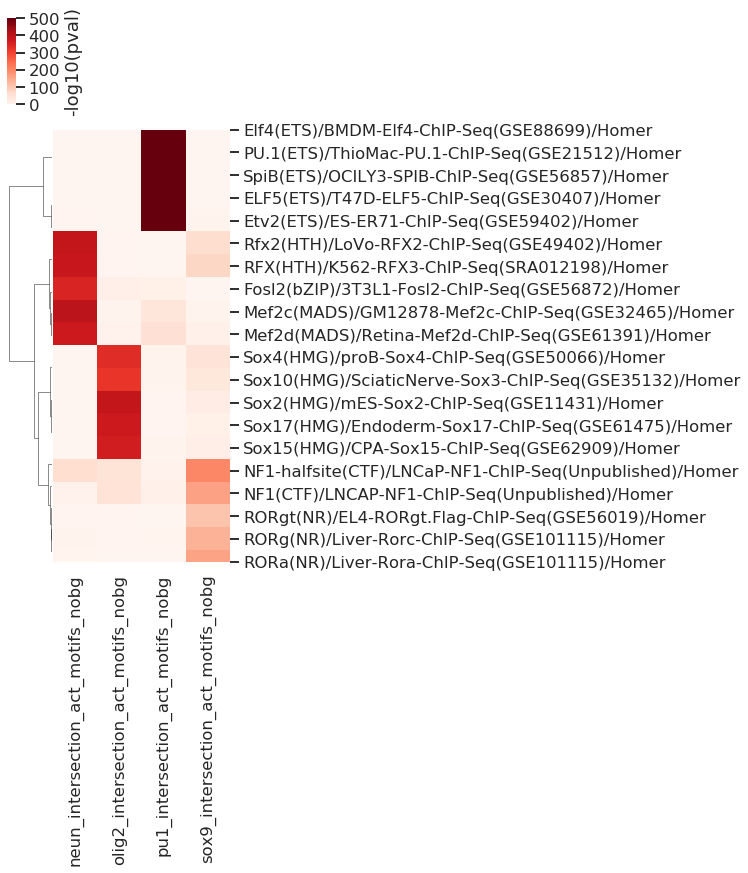

In [37]:
sns.clustermap(
    -tmp_frame.loc[top_motifs, :],
    cmap='Reds',
    #linewidths=1,
    #linecolor='k',
    #annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # row_cluster=False,
    vmax=500,
    # square=True,
    # center=0,
    # ax=ax,
    # col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(4,10))

plt.savefig('./figures/known_motif_intersection_top5_motifs_per_strain.png',
            bbox_inches='tight')

In [47]:
top_motifs = []
top_n = 10

# subset for only cell type unique peaks
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('intersection')]

# selet top motifs per comparison
for col in tmp_frame.columns:
    top_motifs.extend(tmp_frame.sort_values(col, ascending=True).index.tolist()[:top_n])
    
top_motifs = set(top_motifs)

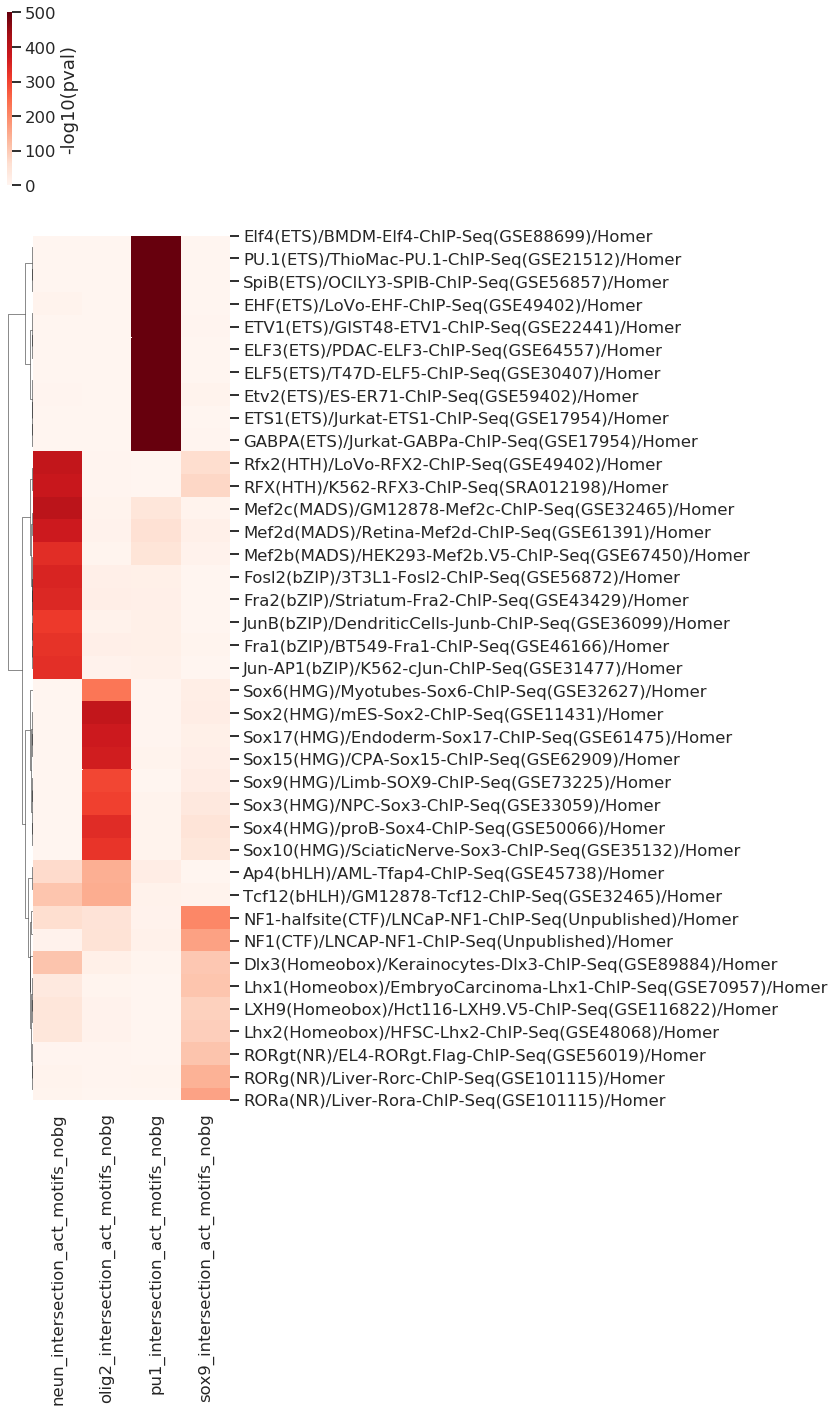

In [48]:
sns.clustermap(
    -tmp_frame.loc[top_motifs, :],
    cmap='Reds',
    #linewidths=1,
    #linecolor='k',
    #annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # row_cluster=False,
    vmax=500,
    # square=True,
    # center=0,
    # ax=ax,
    # col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(4,20))

plt.savefig('./figures/known_motif_intersection_top10_motifs_per_strain.png',
            bbox_inches='tight')

# Union peaks

In [49]:
top_motifs = []
top_n = 5

# subset for only cell type unique peaks
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]

# selet top motifs per comparison
for col in tmp_frame.columns:
    top_motifs.extend(tmp_frame.sort_values(col, ascending=True).index.tolist()[:top_n])
    
top_motifs = set(top_motifs)

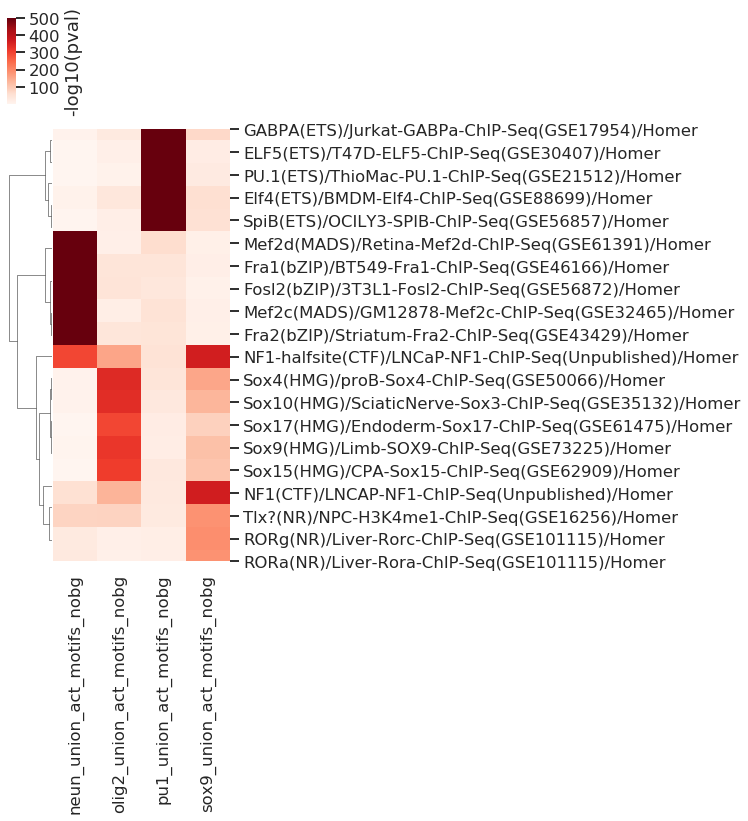

In [50]:
sns.clustermap(
    -tmp_frame.loc[top_motifs, :],
    cmap='Reds',
    #linewidths=1,
    #linecolor='k',
    #annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # row_cluster=False,
    vmax=500,
    # square=True,
    # center=0,
    # ax=ax,
    # col_colors=['#31a354', '#3182bd', '#de2d26'],
    figsize=(4,10))

plt.savefig('./figures/known_motif_union_top5_motifs_per_strain.png',
            bbox_inches='tight')

In [51]:
top_motifs = []
top_n = 10

# subset for only cell type unique peaks
tmp_frame = known_motif_pval_frame.loc[:, known_motif_pval_frame.columns.str.contains('union')]

# selet top motifs per comparison
for col in tmp_frame.columns:
    top_motifs.extend(tmp_frame.sort_values(col, ascending=True).index.tolist()[:top_n])
    
top_motifs = set(top_motifs)

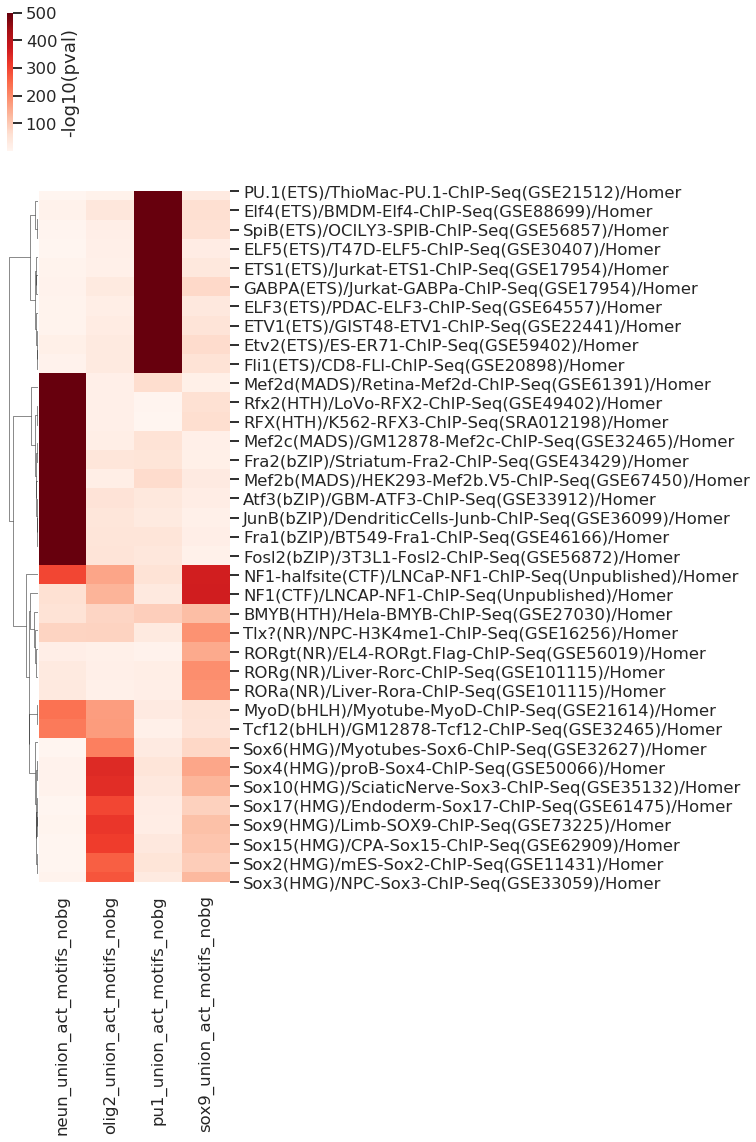

In [54]:
sns.clustermap(
    -tmp_frame.loc[top_motifs, :],
    cmap='Reds',
    #linewidths=1,
    #linecolor='k',
    #annot=True,
    cbar_kws={'label': '-log10(pval)'},
    col_cluster=False,
    # row_cluster=False,
    vmax=500,
    # square=True,
    # center=0,
    # ax=ax,
    # col_colors=['#31a354', '#3182bd', '#de2d26'],
    yticklabels=1,
    figsize=(4,16))

plt.savefig('./figures/known_motif_union_top10_motifs_per_strain.png',
            bbox_inches='tight')